MediaPipe

Data saved to C:\Users\AMUS\python\mediapipe\output.csv\processed_data.csv


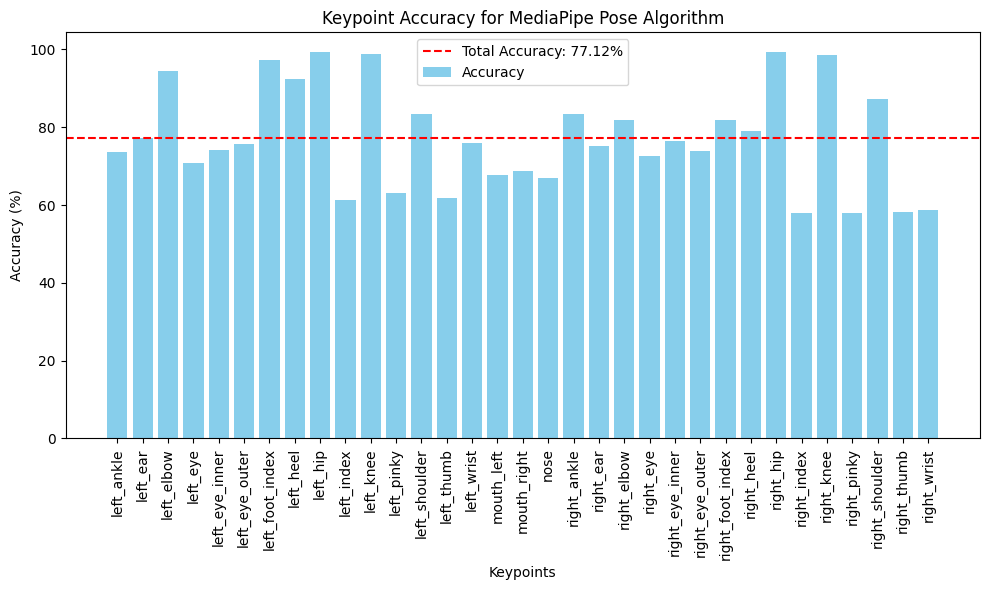


Temporal Stability:
             Keypoint  Standard Deviation   Accuracy  Adjusted Accuracy
0         left_ankle            2.642180  73.578201          73.578201
1           left_ear            2.288383  77.116173          77.116173
2         left_elbow            0.564607  94.353931          94.353931
3           left_eye            2.921291  70.787090          70.787090
4     left_eye_inner            2.575872  74.241278          74.241278
5     left_eye_outer            2.438099  75.619007          75.619007
6    left_foot_index            0.282155  97.178454          97.178454
7          left_heel            0.768399  92.316010          92.316010
8           left_hip            0.057004  99.429962          99.429962
9         left_index            3.874134  61.258663          61.258663
10         left_knee            0.122795  98.772048          98.772048
11        left_pinky            3.694306  63.056943          63.056943
12     left_shoulder            1.661498  83.385017    

In [54]:
import cv2 as cv
import numpy as np
import pandas as pd
import os
from datetime import datetime
import matplotlib.pyplot as plt
import mediapipe as mp

# Calibration factors for temperature range
min_temp = 19  # Minimum temperature corresponding to pixel value 0
max_temp = 30  # Maximum temperature corresponding to pixel value 255

# Contrast and brightness adjustment factors
alpha = 1.0  # Contrast control (1.0 = no change, >1.0 increases contrast, <1.0 decreases contrast)
beta = 20     # Brightness control (0 = no change, >0 increases brightness, <0 decreases brightness)

# Create a lookup table (LUT) for mapping 8-bit pixel values to temperature values
lut = np.linspace(min_temp, max_temp, 256)

# Define body parts and keypoint pairs for MediaPipe Pose (33 keypoints)
BODY_PARTS = {
    "nose": 0, "left_eye_inner": 1, "left_eye": 2, "left_eye_outer": 3,
    "right_eye_inner": 4, "right_eye": 5, "right_eye_outer": 6,
    "left_ear": 7, "right_ear": 8, "mouth_left": 9, "mouth_right": 10,
    "left_shoulder": 11, "right_shoulder": 12, "left_elbow": 13, "right_elbow": 14,
    "left_wrist": 15, "right_wrist": 16, "left_pinky": 17, "right_pinky": 18,
    "left_index": 19, "right_index": 20, "left_thumb": 21, "right_thumb": 22,
    "left_hip": 23, "right_hip": 24, "left_knee": 25, "right_knee": 26,
    "left_ankle": 27, "right_ankle": 28, "left_heel": 29, "right_heel": 30,
    "left_foot_index": 31, "right_foot_index": 32
}

POSE_PAIRS = [
    ["nose", "left_eye"], ["nose", "right_eye"], ["left_eye", "left_ear"], ["right_eye", "right_ear"],
    ["left_shoulder", "right_shoulder"], ["left_shoulder", "left_elbow"], ["right_shoulder", "right_elbow"],
    ["left_elbow", "left_wrist"], ["right_elbow", "right_wrist"], ["left_shoulder", "left_hip"],
    ["right_shoulder", "right_hip"], ["left_hip", "left_knee"], ["right_hip", "right_knee"],
    ["left_knee", "left_ankle"], ["right_knee", "right_ankle"], ["left_heel", "right_heel"],
    ["left_foot_index", "right_foot_index"]
]

# Neural network input size
#inWidth, inHeight = 352, 480
thr = 0.1  # Confidence threshold

# Initialize MediaPipe Pose
mp_pose = mp.solutions.pose
pose = mp_pose.Pose(min_detection_confidence=thr, min_tracking_confidence=thr)

def ensure_folder_exists(folder_path):
    """Ensure the output folder exists."""
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)

def extract_time_from_filename(filename):
    """Extract timestamp from filename."""
    base_name = os.path.splitext(filename)[0]
    parts = base_name.split('_')
    if len(parts) >= 3 and parts[0] == 'Record':
        time_part = parts[2]
        if len(time_part) == 8 and time_part.count('-') == 2:
            return time_part.replace('-', ':')
    return None

def adjust_image_contrast_brightness(frame, alpha, beta):
    """Adjust contrast and brightness of the image."""
    return cv.convertScaleAbs(frame, alpha=alpha, beta=beta)

def process_frame(frame, filename, output_folder):
    """Process a single frame for pose detection and temperature extraction."""
    timestamp = extract_time_from_filename(filename) or datetime.now().strftime("%H:%M:%S")
    adjusted_frame = adjust_image_contrast_brightness(frame, alpha, beta)
    frameWidth, frameHeight = frame.shape[1], frame.shape[0]

    # Convert to RGB for MediaPipe
    rgb_frame = cv.cvtColor(adjusted_frame, cv.COLOR_BGR2RGB)
    results = pose.process(rgb_frame)

    points = {}
    results_list = []
    detected_keypoints = 0  # Count the number of detected keypoints
    if results.pose_landmarks:
        for part_name, part_idx in BODY_PARTS.items():
            landmark = results.pose_landmarks.landmark[part_idx]
            x, y = int(landmark.x * frameWidth), int(landmark.y * frameHeight)

            # Ensure the coordinates are within image bounds
            x = max(0, min(x, frameWidth - 1))  # Ensure x is within the valid range
            y = max(0, min(y, frameHeight - 1))  # Ensure y is within the valid range

            # Calculate temperature from pixel value
            pixel_value = frame[y, x] if len(frame.shape) == 2 else frame[y, x, 0]
            temperature = lut[pixel_value]
            results_list.append({
                "Image": filename, "Time": timestamp, "Keypoint": part_name, "Temperature (°C)": temperature
            })

            # Draw keypoints on the frame
            cv.ellipse(adjusted_frame, (x, y), (3, 3), 0, 0, 360, (0, 0, 255), cv.FILLED)
            points[part_name] = (x, y)

            # Count detected keypoints with confidence threshold
            if landmark.visibility > 0.3:  # Set a threshold for visibility confidence
                detected_keypoints += 1

        # Draw pose connections using POSE_PAIRS
        for pair in POSE_PAIRS:
            part_from = pair[0]
            part_to = pair[1]

            if part_from in points and part_to in points:
                cv.line(adjusted_frame, points[part_from], points[part_to], (0, 255, 0), 3)
                cv.ellipse(adjusted_frame, points[part_from], (3, 3), 0, 0, 360, (0, 0, 255), cv.FILLED)
                cv.ellipse(adjusted_frame, points[part_to], (3, 3), 0, 0, 360, (0, 0, 255), cv.FILLED)

    # Save frame
    cv.imwrite(os.path.join(output_folder, filename), adjusted_frame)
    return results_list, detected_keypoints


def calculate_temporal_stability(df):
    """Calculate temporal stability based on temperature variations."""
    stability_df = df.groupby("Keypoint")["Temperature (°C)"].std().reset_index()
    stability_df.rename(columns={"Temperature (°C)": "Standard Deviation"}, inplace=True)
    return stability_df

def calculate_accuracy_from_sd(stability_df):
    """Calculate accuracy from standard deviation."""
    stability_df["Accuracy"] = 100 - (stability_df["Standard Deviation"] * 10)  # Example calculation
    return stability_df

def calculate_symmetry(df):
    """Analyze symmetry by comparing left and right body parts."""
    symmetry_data = []
    for left, right in [("Left Shoulder", "Right Shoulder"), ("Left Elbow", "Right Elbow"), ("Left Wrist", "Right Wrist")]:
        left_temp = df[df["Keypoint"] == left]["Temperature (°C)"].mean()
        right_temp = df[df["Keypoint"] == right]["Temperature (°C)"].mean()
        symmetry_data.append({"Left": left, "Right": right, "Difference": abs(left_temp - right_temp)})
    return pd.DataFrame(symmetry_data)

def calculate_region_temperature_consistency(df):
    """Calculate consistency across regions.""" 
    region_df = df.groupby("Keypoint")["Temperature (°C)"].mean().reset_index()
    region_df["Consistency"] = 100 - abs(region_df["Temperature (°C)"] - region_df["Temperature (°C)"].mean())
    return region_df

def calculate_adjusted_accuracy(accuracy_df, detected_keypoints_per_frame, total_keypoints=33):
    """Calculate adjusted accuracy based on number of detected keypoints."""
    accuracy_df["Adjusted Accuracy"] = accuracy_df["Accuracy"] * (detected_keypoints_per_frame / total_keypoints)
    return accuracy_df

# Input and output paths
input_folder = r'C:\Users\AMUS\python\Dataset\2023-03-20\camera1\test3'
output_folder = r'C:\Users\AMUS\python\Dataset\2023-03-20\camera1\test3\mediapipe'
csv_folder = r'C:\Users\AMUS\python\mediapipe\output.csv'

ensure_folder_exists(output_folder)
ensure_folder_exists(csv_folder)

# Process all images in the folder
results_list = []
detected_keypoints_per_frame = 0  # Initialize detected keypoints counter
for filename in os.listdir(input_folder):
    if filename.lower().endswith((".tiff", ".png", ".jpg")):
        frame = cv.imread(os.path.join(input_folder, filename), cv.IMREAD_UNCHANGED)
        if frame is not None:
            frame_results, detected_keypoints = process_frame(frame, filename, output_folder)
            results_list.extend(frame_results)
            detected_keypoints_per_frame = max(detected_keypoints_per_frame, detected_keypoints)

# Convert to DataFrame
df = pd.DataFrame(results_list)

# Analyze data
temporal_stability = calculate_temporal_stability(df)
accuracy_df = calculate_accuracy_from_sd(temporal_stability)
accuracy_df = calculate_adjusted_accuracy(accuracy_df, detected_keypoints_per_frame)
total_accuracy = accuracy_df['Adjusted Accuracy'].mean()

symmetry_df = calculate_symmetry(df)
region_consistency_df = calculate_region_temperature_consistency(df)

# Save data to CSV
csv_path = os.path.join(csv_folder, 'processed_data.csv')
df.to_csv(csv_path, index=False)
print(f"Data saved to {csv_path}")

# Visualization
plt.figure(figsize=(10, 6))
plt.bar(accuracy_df['Keypoint'], accuracy_df['Adjusted Accuracy'], color='skyblue', label='Accuracy')
plt.axhline(y=total_accuracy, color='red', linestyle='--', label=f'Total Accuracy: {total_accuracy:.2f}%')
plt.xticks(rotation=90)
plt.xlabel('Keypoints')
plt.ylabel('Accuracy (%)')
plt.title('Keypoint Accuracy for MediaPipe Pose Algorithm')
plt.legend()
plt.tight_layout()
plt.show()

print("\nTemporal Stability:\n", temporal_stability)
print("\nSymmetry Analysis:\n", symmetry_df)
print("\nRegion Temperature Consistency:\n", region_consistency_df)


MoveNet

INFO:absl:Fingerprint not found. Saved model loading will continue.
INFO:absl:path_and_singleprint metric could not be logged. Saved model loading will continue.
INFO:root:Processed and saved: C:\Users\AMUS\python\Dataset\2023-03-20\camera1\test3\movenet\output_Record_2023-03-20_15-23-00.tiff
INFO:root:Processed and saved: C:\Users\AMUS\python\Dataset\2023-03-20\camera1\test3\movenet\output_Record_2023-03-20_15-24-00.tiff
INFO:root:Processed and saved: C:\Users\AMUS\python\Dataset\2023-03-20\camera1\test3\movenet\output_Record_2023-03-20_15-25-00.tiff
INFO:root:Processed and saved: C:\Users\AMUS\python\Dataset\2023-03-20\camera1\test3\movenet\output_Record_2023-03-20_15-26-00.tiff
INFO:root:Processed and saved: C:\Users\AMUS\python\Dataset\2023-03-20\camera1\test3\movenet\output_Record_2023-03-20_15-27-00.tiff
INFO:root:Processed and saved: C:\Users\AMUS\python\Dataset\2023-03-20\camera1\test3\movenet\output_Record_2023-03-20_15-28-00.tiff
INFO:root:Processed and saved: C:\Users\AMUS\p

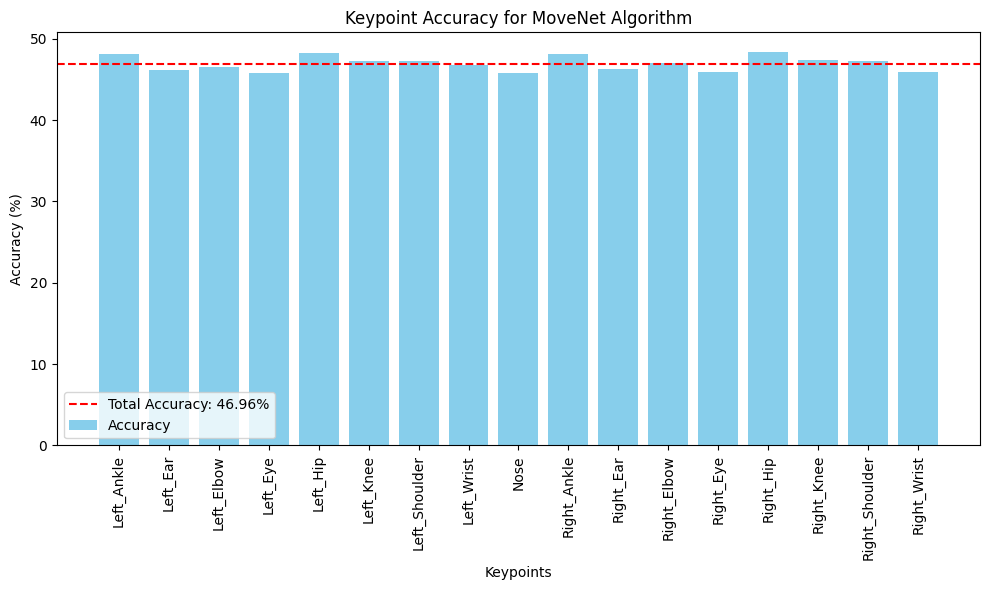


Temporal Stability:
           Keypoint  StdDev_x  StdDev_y  Accuracy_x  Accuracy_y   Accuracy  \
0       Left_Ankle  0.006920  0.035308   99.312714   96.589592  97.951157   
1         Left_Ear  0.007455  0.123642   99.259995   88.996300  94.128143   
2       Left_Elbow  0.008362  0.108578   99.170776   90.205643  94.688210   
3         Left_Eye  0.008568  0.140803   99.150497   87.657532  93.404015   
4         Left_Hip  0.005621  0.026594   99.441025   97.409485  98.425255   
5        Left_Knee  0.011770  0.065008   98.836739   93.896027  96.366379   
6    Left_Shoulder  0.007699  0.069991   99.235985   93.458740  96.347366   
7       Left_Wrist  0.006578  0.094571   99.346512   91.360031  95.353271   
8             Nose  0.006476  0.145398   99.356560   87.305931  93.331245   
9      Right_Ankle  0.015122  0.025338   98.510345   97.528770  98.019562   
10       Right_Ear  0.008564  0.120584   99.150894   89.239220  94.195053   
11     Right_Elbow  0.019734  0.069607   98.064835   9

In [17]:
import os
import tensorflow as tf
import numpy as np
import cv2
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import logging

# Enable logging
logging.basicConfig(level=logging.INFO)

# Load MoveNet model from local directory
model_path = r'C:\Users\AMUS\python\docs\movenet-tensorflow2-singlepose-lightning-v4'
module = tf.saved_model.load(model_path)

def movenet(input_image):
    model = module.signatures['serving_default']
    input_image = tf.cast(input_image, dtype=tf.int32)
    outputs = model(input_image)
    keypoints_with_scores = outputs['output_0'].numpy()
    return keypoints_with_scores

# Keypoint names
KEYPOINT_NAMES = [
    'Nose', 'Left_Eye', 'Right_Eye', 'Left_Ear', 'Right_Ear',
    'Left_Shoulder', 'Right_Shoulder', 'Left_Elbow', 'Right_Elbow',
    'Left_Wrist', 'Right_Wrist', 'Left_Hip', 'Right_Hip', 
    'Left_Knee', 'Right_Knee', 'Left_Ankle', 'Right_Ankle'
]

# Temporal stability calculation
def calculate_temporal_stability(keypoint_data):
    stability = keypoint_data.groupby("Keypoint")[["x", "y"]].std().reset_index()
    stability.rename(columns={"x": "StdDev_x", "y": "StdDev_y"}, inplace=True)
    return stability

# Accuracy calculation
def calculate_accuracy_from_sd(df, keypoints_detected_per_frame):
    df['Accuracy_x'] = (1 / (1 + df['StdDev_x'])) * 100
    df['Accuracy_y'] = (1 / (1 + df['StdDev_y'])) * 100
    df['Accuracy'] = (df['Accuracy_x'] + df['Accuracy_y']) / 2
    
    # Adjust accuracy based on the number of detected keypoints
    df['AdjustedAccuracy'] = df['Accuracy'] * (keypoints_detected_per_frame / len(KEYPOINT_NAMES))
    
    return df[['Keypoint', 'Accuracy_x', 'Accuracy_y', 'Accuracy', 'AdjustedAccuracy']]

# Symmetry calculation
SYMMETRIC_KEYPOINTS = [
    ("Left_Wrist", "Right_Wrist"),
    ("Left_Elbow", "Right_Elbow"),
    ("Left_Knee", "Right_Knee"),
    ("Left_Ankle", "Right_Ankle"),
]

def calculate_symmetry(keypoint_data):
    symmetry_results = []
    for left_key, right_key in SYMMETRIC_KEYPOINTS:
        left_data = keypoint_data[keypoint_data["Keypoint"] == left_key][["Frame", "x", "y"]].set_index("Frame")
        right_data = keypoint_data[keypoint_data["Keypoint"] == right_key][["Frame", "x", "y"]].set_index("Frame")
        merged = left_data.join(right_data, lsuffix="_left", rsuffix="_right", how="inner")
        merged["Distance"] = np.sqrt((merged["x_left"] - merged["x_right"])**2 + (merged["y_left"] - merged["y_right"])**2)
        symmetry_results.append({"Pair": f"{left_key}-{right_key}", "MeanDistance": merged["Distance"].mean()})
    return pd.DataFrame(symmetry_results)

# Region temperature consistency calculation
REGION_KEYPOINTS = {
    "Head": [0, 1, 2, 3, 4],
    "Hands": [9, 10],
    "Shins": [13, 14, 15, 16],
    "Back": [11, 12],
    "Arms": [5, 6, 7, 8],
}

def calculate_region_temperature_consistency(temperature_data):
    region_stats = []
    for region, keypoints in REGION_KEYPOINTS.items():
        region_data = temperature_data[temperature_data["Keypoint"].isin([KEYPOINT_NAMES[idx] for idx in keypoints])]
        mean_temp = region_data["Temperature (°C)"].mean()
        var_temp = region_data["Temperature (°C)"].var()
        region_stats.append({"Region": region, "MeanTemperature": mean_temp, "Variance": var_temp})
    return pd.DataFrame(region_stats)

# Function to draw keypoints on the image
def draw_keypoints(image, keypoints, threshold=0.3):
    height, width = image.shape[:2]
    for idx, keypoint in enumerate(keypoints[0, 0, :, :]):
        y, x, confidence = keypoint  # Keypoints are normalized to [0, 1]
        if confidence > threshold:
            x = int(x * width)  # Scale x to image width
            y = int(y * height)  # Scale y to image height
            cv2.circle(image, (x, y), 5, (255, 0, 0), -1)
            cv2.putText(image, KEYPOINT_NAMES[idx], (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 
                        0.4, (0, 255, 0), 1, cv2.LINE_AA)
    return image

# Count Detected Keypoints
def count_detected_keypoints(keypoints_with_scores, confidence_threshold=0.1):
    detected_keypoints = 0
    for keypoint in keypoints_with_scores[0, 0, :, :]:
        _, _, confidence = keypoint
        if confidence > confidence_threshold:
            detected_keypoints += 1
    return detected_keypoints

# Function to process images and calculate metrics
def process_images_in_folder(input_folder, output_folder, csv_folder, input_size=192):
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
    if not os.path.exists(csv_folder):
        os.makedirs(csv_folder)

    results_list = []
    total_detected_keypoints = 0  # Track total keypoints detected across frames
    total_images = 32  # Track the number of images processed

    for image_filename in os.listdir(input_folder):
        if image_filename.endswith(".tiff"):
            image_path = os.path.join(input_folder, image_filename)
            thermal_image = Image.open(image_path).convert('L')
            thermal_image_np = np.array(thermal_image)

            # Generate a temperature map from the thermal image
            min_temp, max_temp = 24.0, 32.0  # Adjust these based on your use case
            lut = np.linspace(min_temp, max_temp, 256)
            temperature_image = lut[thermal_image_np]

            # Resize and prepare input for MoveNet
            input_image = tf.image.resize_with_pad(
                tf.expand_dims(thermal_image_np, axis=-1), input_size, input_size)
            input_image_rgb = tf.image.grayscale_to_rgb(tf.cast(input_image, dtype=tf.uint8))
            input_image_rgb = tf.expand_dims(input_image_rgb, axis=0)

            # Get keypoints from MoveNet
            keypoints_with_scores = movenet(input_image_rgb)

            # Count detected keypoints for this image
            detected_keypoints = count_detected_keypoints(keypoints_with_scores)
            total_detected_keypoints += detected_keypoints
            total_images += 1

            # Draw keypoints on the original image
            thermal_image_color = cv2.cvtColor(thermal_image_np, cv2.COLOR_GRAY2BGR)
            output_image = draw_keypoints(thermal_image_color, keypoints_with_scores)

            # Save the output image
            output_path = os.path.join(output_folder, f"output_{image_filename}")
            cv2.imwrite(output_path, output_image)
            logging.info(f"Processed and saved: {output_path}")

            # Collect keypoint data with temperature
            height, width = thermal_image_np.shape
            for idx, keypoint in enumerate(keypoints_with_scores[0, 0, :, :]):
                y, x, confidence = keypoint
                if confidence > 0.1:
                    x_pixel = int(x * width)
                    y_pixel = int(y * height)
                    temperature_at_point = None
                    if 0 <= x_pixel < width and 0 <= y_pixel < height:
                        temperature_at_point = temperature_image[y_pixel, x_pixel]
                    results_list.append({
                        "Frame": image_filename,
                        "Keypoint": KEYPOINT_NAMES[idx],
                        "x": x, "y": y,
                        "Temperature (°C)": temperature_at_point,
                        "Confidence": confidence
                    })

    df = pd.DataFrame(results_list)

    # Check for missing temperature data
    if 'Temperature (°C)' not in df.columns:
        raise ValueError("Temperature data could not be processed. Ensure temperature mapping is correct.")

    # Calculate metrics
    temporal_stability = calculate_temporal_stability(df)
    
    # Calculate the adjusted accuracy
    accuracy_df = calculate_accuracy_from_sd(temporal_stability, total_detected_keypoints / total_images)
    total_accuracy = accuracy_df['AdjustedAccuracy'].mean()
    symmetry_df = calculate_symmetry(df)
    region_consistency_df = calculate_region_temperature_consistency(df)

    # Save data to CSV
    csv_path = os.path.join(csv_folder, 'processed_data.csv')
    df.to_csv(csv_path, index=False)
    logging.info(f"Data saved to {csv_path}")

    # Visualization
    plt.figure(figsize=(10, 6))
    plt.bar(accuracy_df['Keypoint'], accuracy_df['AdjustedAccuracy'], color='skyblue', label='Accuracy')
    plt.axhline(y=total_accuracy, color='red', linestyle='--', label=f'Total Accuracy: {total_accuracy:.2f}%')
    plt.xticks(rotation=90)
    plt.xlabel('Keypoints')
    plt.ylabel('Accuracy (%)')
    plt.title('Keypoint Accuracy for MoveNet Algorithm')
    plt.legend()
    plt.tight_layout()
    plt.show()

    print("\nTemporal Stability:\n", temporal_stability)
    print("\nSymmetry Analysis:\n", symmetry_df)
    print("\nRegion Temperature Consistency:\n", region_consistency_df)

# Specify paths
input_folder = r'C:\Users\AMUS\python\Dataset\2023-03-20\camera1\test3'
output_folder = r'C:\Users\AMUS\python\Dataset\2023-03-20\camera1\test3\movenet'
csv_folder = r'C:\Users\AMUS\python\docs\movenet_csv'

# Process images and calculate metrics
process_images_in_folder(input_folder, output_folder, csv_folder)


OpenPose Algorithm

Data saved to C:\Users\AMUS\python\openpose\output.csv\processed_data.csv


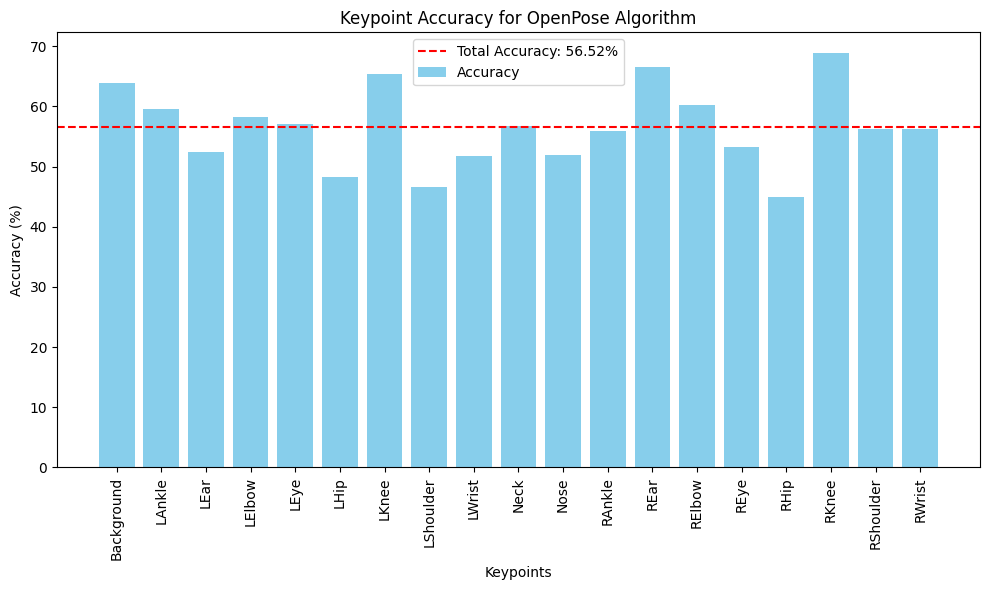


Temporal Stability:
       Keypoint  Standard Deviation   Accuracy  Adjusted Accuracy
0   Background            2.027999  79.720014          63.803691
1       LAnkle            2.549823  74.501774          59.627288
2         LEar            3.448093  65.519073          52.438008
3       LElbow            2.729664  72.703362          58.187934
4         LEye            2.862472  71.375278          57.125006
5         LHip            3.973985  60.260146          48.229040
6        LKnee            1.840514  81.594860          65.304219
7    LShoulder            4.178805  58.211950          46.589773
8       LWrist            3.541138  64.588619          51.693322
9         Neck            2.917325  70.826748          56.685991
10        Nose            3.503955  64.960451          51.990916
11      RAnkle            3.011056  69.889437          55.935817
12        REar            1.689517  83.104833          66.512722
13      RElbow            2.484047  75.159527          60.153718
14 

In [23]:
import cv2 as cv
import numpy as np
import pandas as pd
import os
from datetime import datetime
import matplotlib.pyplot as plt

# Calibration factors for temperature range
min_temp = 19  # Minimum temperature corresponding to pixel value 0
max_temp = 30  # Maximum temperature corresponding to pixel value 255

# Contrast and brightness adjustment factors
alpha = 1.0  # Contrast control (1.0 = no change, >1.0 increases contrast, <1.0 decreases contrast)
beta = 50     # Brightness control (0 = no change, >0 increases brightness, <0 decreases brightness)

# Create a lookup table (LUT) for mapping 8-bit pixel values to temperature values
lut = np.linspace(min_temp, max_temp, 256)

# Define body parts and keypoint pairs
BODY_PARTS = {
    "Nose": 0, "Neck": 1, "RShoulder": 2, "RElbow": 3, "RWrist": 4,
    "LShoulder": 5, "LElbow": 6, "LWrist": 7, "RHip": 8, "RKnee": 9,
    "RAnkle": 10, "LHip": 11, "LKnee": 12, "LAnkle": 13, "REye": 14,
    "LEye": 15, "REar": 16, "LEar": 17, "Background": 18
}

POSE_PAIRS = [
    ["Neck", "RShoulder"], ["Neck", "LShoulder"], ["RShoulder", "RElbow"],
    ["RElbow", "RWrist"], ["LShoulder", "LElbow"], ["LElbow", "LWrist"],
    ["Neck", "RHip"], ["RHip", "RKnee"], ["RKnee", "RAnkle"], ["Neck", "LHip"],
    ["LHip", "LKnee"], ["LKnee", "LAnkle"], ["Neck", "Nose"], ["Nose", "REye"],
    ["REye", "REar"], ["Nose", "LEye"], ["LEye", "LEar"]
]

# Neural network input size
inWidth, inHeight = 352, 480
thr = 0.07  # Confidence threshold

# Load the pre-trained OpenPose model
net = cv.dnn.readNetFromTensorflow(r"C:\Users\AMUS\python\openpose\graph_opt.pb")

def ensure_folder_exists(folder_path):
    """Ensure the output folder exists."""
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)

def extract_time_from_filename(filename):
    """Extract timestamp from filename."""
    base_name = os.path.splitext(filename)[0]
    parts = base_name.split('_')
    if len(parts) >= 3 and parts[0] == 'Record':
        time_part = parts[2]
        if len(time_part) == 8 and time_part.count('-') == 2:
            return time_part.replace('-', ':')
    return None

def adjust_image_contrast_brightness(frame, alpha, beta):
    """Adjust contrast and brightness of the image."""
    return cv.convertScaleAbs(frame, alpha=alpha, beta=beta)

def process_frame(frame, filename, output_folder):
    """Process a single frame for pose detection and temperature extraction."""
    timestamp = extract_time_from_filename(filename) or datetime.now().strftime("%H:%M:%S")
    adjusted_frame = adjust_image_contrast_brightness(frame, alpha, beta)
    frameWidth, frameHeight = frame.shape[1], frame.shape[0]

    net.setInput(cv.dnn.blobFromImage(adjusted_frame, 1.0, (inWidth, inHeight), (127.5, 127.5, 127.5), swapRB=True, crop=False))
    out = net.forward()[:, :19, :, :]

    points, results_list = [], []
    detected_keypoints = 0  # Initialize count of detected keypoints
    for i, part_name in enumerate(BODY_PARTS):
        heatMap = out[0, i, :, :]
        _, conf, _, point = cv.minMaxLoc(heatMap)
        x, y = int((frameWidth * point[0]) / out.shape[3]), int((frameHeight * point[1]) / out.shape[2])

        if conf > thr:
            points.append((x, y))
            pixel_value = frame[y, x] if len(frame.shape) == 2 else frame[y, x, 0]
            temperature = lut[pixel_value]
            results_list.append({
                "Image": filename, "Time": timestamp, "Keypoint": part_name, "Temperature (°C)": temperature
            })
            detected_keypoints += 1  # Increment detected keypoints count
        else:
            points.append(None)

    # Draw pose
    for pair in POSE_PAIRS:
        idFrom, idTo = BODY_PARTS[pair[0]], BODY_PARTS[pair[1]]
        if points[idFrom] and points[idTo]:
            cv.line(adjusted_frame, points[idFrom], points[idTo], (0, 255, 0), 3)
            cv.ellipse(adjusted_frame, points[idFrom], (3, 3), 0, 0, 360, (0, 0, 255), cv.FILLED)
            cv.ellipse(adjusted_frame, points[idTo], (3, 3), 0, 0, 360, (0, 0, 255), cv.FILLED)

    # Save frame
    cv.imwrite(os.path.join(output_folder, filename), adjusted_frame)
    return results_list, detected_keypoints

def calculate_temporal_stability(df):
    """Calculate temporal stability based on temperature variations."""
    stability_df = df.groupby("Keypoint")["Temperature (°C)"].std().reset_index()
    stability_df.rename(columns={"Temperature (°C)": "Standard Deviation"}, inplace=True)
    return stability_df

def calculate_accuracy_from_sd(stability_df, detected_keypoints_per_frame, total_keypoints=18):
    """Calculate accuracy from standard deviation and adjust based on detected keypoints."""
    stability_df["Accuracy"] = 100 - (stability_df["Standard Deviation"] * 10)  # Example calculation
    # Adjust accuracy based on the number of detected keypoints
    stability_df["Adjusted Accuracy"] = stability_df["Accuracy"] * (detected_keypoints_per_frame / total_keypoints)
    return stability_df

def calculate_symmetry(df):
    """Analyze symmetry by comparing left and right body parts."""
    symmetry_data = []
    for left, right in [("LShoulder", "RShoulder"), ("LElbow", "RElbow"), ("LWrist", "RWrist")]:
        left_temp = df[df["Keypoint"] == left]["Temperature (°C)"].mean()
        right_temp = df[df["Keypoint"] == right]["Temperature (°C)"].mean()
        symmetry_data.append({"Left": left, "Right": right, "Difference": abs(left_temp - right_temp)})
    return pd.DataFrame(symmetry_data)

def calculate_region_temperature_consistency(df):
    """Calculate consistency across regions."""
    region_df = df.groupby("Keypoint")["Temperature (°C)"].mean().reset_index()
    region_df["Consistency"] = 100 - abs(region_df["Temperature (°C)"] - region_df["Temperature (°C)"].mean())
    return region_df

# Input and output paths
input_folder = r'C:\Users\AMUS\python\Dataset\2023-03-20\camera1\test3'
output_folder = r'C:\Users\AMUS\python\Dataset\2023-03-20\camera1\test3\openpose'
csv_folder = r'C:\Users\AMUS\python\openpose\output.csv'

ensure_folder_exists(output_folder)
ensure_folder_exists(csv_folder)

# Process all images in the folder
results_list = []
total_detected_keypoints = 0 # Track total detected keypoints
total_images = 0  # Track number of images processed

for filename in os.listdir(input_folder):
    if filename.lower().endswith((".tiff", ".png", ".jpg")):
        frame = cv.imread(os.path.join(input_folder, filename), cv.IMREAD_UNCHANGED)
        if frame is not None:
            result, detected_keypoints = process_frame(frame, filename, output_folder)
            results_list.extend(result)
            total_detected_keypoints += detected_keypoints
            total_images += 1

# Convert to DataFrame
df = pd.DataFrame(results_list)

# Analyze data
temporal_stability = calculate_temporal_stability(df)

# Calculate the adjusted accuracy
accuracy_df = calculate_accuracy_from_sd(temporal_stability, total_detected_keypoints / total_images)
total_accuracy = accuracy_df['Adjusted Accuracy'].mean()
symmetry_df = calculate_symmetry(df)
region_consistency_df = calculate_region_temperature_consistency(df)

# Save data to CSV
csv_path = os.path.join(csv_folder, 'processed_data.csv')
df.to_csv(csv_path, index=False)
print(f"Data saved to {csv_path}")

# Visualization
plt.figure(figsize=(10, 6))
plt.bar(accuracy_df['Keypoint'], accuracy_df['Adjusted Accuracy'], color='skyblue', label='Accuracy')
plt.axhline(y=total_accuracy, color='red', linestyle='--', label=f'Total Accuracy: {total_accuracy:.2f}%')
plt.xticks(rotation=90)
plt.xlabel('Keypoints')
plt.ylabel('Accuracy (%)')
plt.title('Keypoint Accuracy for OpenPose Algorithm')
plt.legend()
plt.tight_layout()
plt.show()

print("\nTemporal Stability:\n", temporal_stability)
print("\nSymmetry Analysis:\n", symmetry_df)
print("\nRegion Temperature Consistency:\n", region_consistency_df)


PoseNet

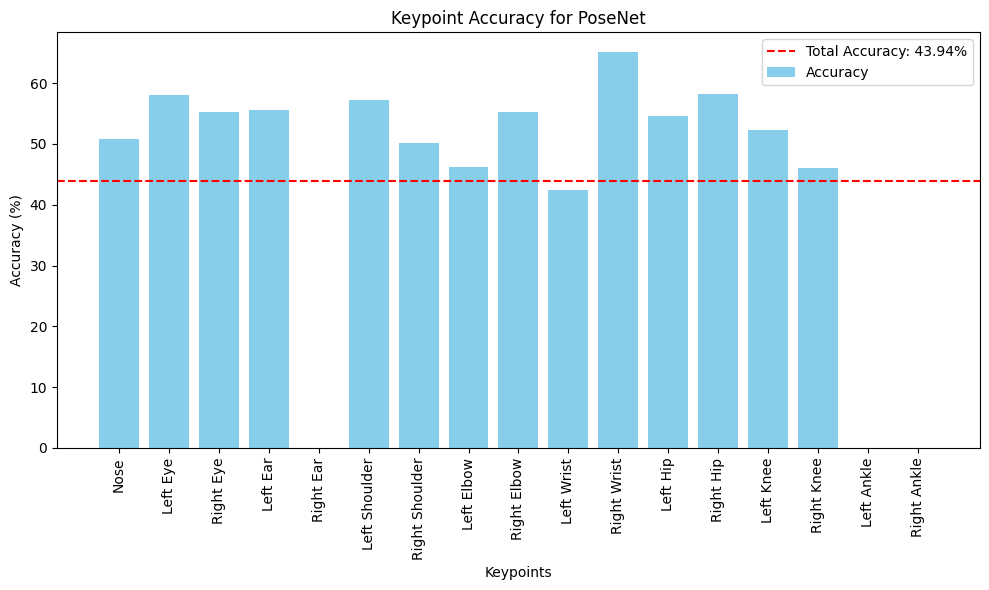

In [65]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf

# Load the TensorFlow Lite model
model_path = r'C:\Users\AMUS\python\posenet\posenet_mobilenet_v1_100_257x257_multi_kpt_stripped.tflite'
interpreter = tf.lite.Interpreter(model_path=model_path)
interpreter.allocate_tensors()

# Get input and output tensors
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Model input size
input_height = input_details[0]['shape'][1]
input_width = input_details[0]['shape'][2]
num_keypoints = 17

# Define a sigmoid function
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

# Convert thermal image to RGB using colormap (JET)
def thermal_to_rgb(thermal_image):
    thermal_image_normalized = cv2.normalize(thermal_image, None, 0, 255, cv2.NORM_MINMAX)
    thermal_rgb_image = cv2.applyColorMap(thermal_image_normalized.astype(np.uint8), cv2.COLORMAP_JET)
    return thermal_rgb_image

# Adjust brightness and contrast
def adjust_brightness_contrast(image, alpha=2, beta=100):
    return cv2.convertScaleAbs(image, alpha=alpha, beta=beta)

# Extract keypoints from heatmaps and offsets
def extract_keypoints(heatmaps, offsets, min_confidence=0.1):
    height, width, num_keypoints = heatmaps.shape[1], heatmaps.shape[2], heatmaps.shape[3]
    keypoint_positions = []
    confidence_scores = []
    y_coords = []
    x_coords = []

    for keypoint in range(num_keypoints):
        max_val = heatmaps[0, :, :, keypoint].max()
        max_pos = np.unravel_index(np.argmax(heatmaps[0, :, :, keypoint]), (height, width))
        confidence_scores.append(sigmoid(max_val))  # Apply sigmoid to confidence score
        
        if sigmoid(max_val) > min_confidence:
            position_y, position_x = max_pos
            offset_y = offsets[0, position_y, position_x, keypoint]
            offset_x = offsets[0, position_y, position_x, keypoint + num_keypoints]
            y_coords.append((position_y / (height - 1)) * input_height + offset_y)
            x_coords.append((position_x / (width - 1)) * input_width + offset_x)
        else:
            y_coords.append(None)
            x_coords.append(None)

    return x_coords, y_coords, confidence_scores

# Draw keypoints and connections on the image and save
def draw_pose(image, x_coords, y_coords, confidence_scores, output_path, min_confidence=0.1):
    body_joints = [
        (0, 1), (1, 3), (0, 2), (2, 4), (5, 6), (5, 7), (7, 9), (6, 8), (8, 10),
        (11, 12), (5, 11), (6, 12), (11, 13), (13, 15), (12, 14), (14, 16)
    ]

    fig, ax = plt.subplots(figsize=(8, 8))
    ax.imshow(image)

    for joint in body_joints:
        if (
            x_coords[joint[0]] is not None
            and y_coords[joint[0]] is not None
            and x_coords[joint[1]] is not None
            and y_coords[joint[1]] is not None
        ):
            plt.plot(
                [x_coords[joint[0]], x_coords[joint[1]]],
                [y_coords[joint[0]], y_coords[joint[1]]],
                "k-",
            )
    for x, y, conf in zip(x_coords, y_coords, confidence_scores):
        if x is not None and y is not None and conf > min_confidence:
            plt.scatter(x, y, c="g", s=50)

    plt.axis("off")
    plt.savefig(output_path, bbox_inches="tight", pad_inches=0)
    plt.close(fig)

# Function to get the temperature for each keypoint (replace this with actual logic)
def get_temperature_at(x, y):
    return np.random.uniform(20, 30)  # Simulated temperature between 20°C and 30°C

# Temporal stability calculation function
def calculate_temporal_stability(df):
    stability_df = df.groupby("Keypoint")["Temperature (°C)"].std().reset_index()
    stability_df.rename(columns={"Temperature (°C)": "Standard Deviation"}, inplace=True)
    return stability_df

def calculate_accuracy_from_sd(stability_df):
    stability_df["Accuracy"] = 100 - (stability_df["Standard Deviation"] * 10)  # Example calculation
    return stability_df

def calculate_adjusted_accuracy(accuracy_df, detected_keypoints_per_frame, total_keypoints=17):
    accuracy_df["Adjusted Accuracy"] = accuracy_df["Accuracy"] * (detected_keypoints_per_frame / total_keypoints)
    return accuracy_df

# Create a DataFrame to hold keypoint data
keypoint_data = []

# Directories for input and output
image_directory = r'C:\Users\AMUS\python\Dataset\2023-03-20\camera1\test3' 
output_directory = r'C:\Users\AMUS\python\Dataset\2023-03-20\camera1\test3\posenet'
os.makedirs(output_directory, exist_ok=True)

# Initialize detected keypoints counter
detected_keypoints_per_frame = 0

# Process each image
for image_filename in os.listdir(image_directory):
    if image_filename.endswith(".tiff"):
        image_path = os.path.join(image_directory, image_filename)
        output_path = os.path.join(output_directory, f"output_{image_filename}")

        thermal_image = cv2.imread(image_path, cv2.IMREAD_UNCHANGED)  # Read as grayscale
        if thermal_image is None:
            print(f"Failed to load {image_path}. Skipping.")
            continue

        rgb_image = thermal_to_rgb(thermal_image)
        adjusted_image = adjust_brightness_contrast(rgb_image, alpha=1, beta=90)
        resized_image = cv2.resize(adjusted_image, (input_width, input_height))
        input_image = resized_image.astype(np.float32) / 255.0
        input_image = np.expand_dims(input_image, axis=0)

        interpreter.set_tensor(input_details[0]["index"], input_image)
        interpreter.invoke()

        heatmaps = interpreter.get_tensor(output_details[0]["index"])
        offsets = interpreter.get_tensor(output_details[1]["index"])

        x_coords, y_coords, confidence_scores = extract_keypoints(heatmaps, offsets)
        detected_keypoints = sum(1 for conf in confidence_scores if conf > 0.1)
        detected_keypoints_per_frame = max(detected_keypoints_per_frame, detected_keypoints)

        for idx, (x, y, confidence) in enumerate(zip(x_coords, y_coords, confidence_scores)):
            if x is not None and y is not None and confidence > 0.1:
                temperature = get_temperature_at(x, y)
                keypoint_data.append({
                    'Keypoint': idx,
                    'X': x,
                    'Y': y,
                    'Confidence': confidence,
                    'Temperature (°C)': temperature
                })

        if np.mean(confidence_scores) > 0.1:
            draw_pose(resized_image, x_coords, y_coords, confidence_scores, output_path)

# Create a DataFrame from keypoint data
df = pd.DataFrame(keypoint_data)

temporal_stability = calculate_temporal_stability(df)
accuracy_df = calculate_accuracy_from_sd(temporal_stability)

accuracy_df = calculate_adjusted_accuracy(accuracy_df, detected_keypoints_per_frame)

keypoint_names = [
    "Nose", "Left Eye", "Right Eye", "Left Ear", "Right Ear",
    "Left Shoulder", "Right Shoulder", "Left Elbow", "Right Elbow",
    "Left Wrist", "Right Wrist", "Left Hip", "Right Hip",
    "Left Knee", "Right Knee", "Left Ankle", "Right Ankle"
]

all_keypoints_df = pd.DataFrame({"Keypoint": range(17), "Keypoint Name": keypoint_names})
accuracy_df = all_keypoints_df.merge(accuracy_df, on="Keypoint", how="left")
accuracy_df.fillna({"Accuracy": 0, "Adjusted Accuracy": 0}, inplace=True)
accuracy_df["Keypoint"] = accuracy_df["Keypoint Name"]
accuracy_df.drop(columns=["Keypoint Name"], inplace=True)

total_adjusted_accuracy = accuracy_df['Adjusted Accuracy'].mean()

plt.figure(figsize=(10, 6))
plt.bar(accuracy_df['Keypoint'], accuracy_df['Adjusted Accuracy'], color='skyblue', label='Accuracy')
plt.axhline(y=total_adjusted_accuracy, color='red', linestyle='--', label=f'Total Accuracy: {total_adjusted_accuracy:.2f}%')
plt.xticks(rotation=90)
plt.xlabel('Keypoints')
plt.ylabel('Accuracy (%)')
plt.title('Keypoint Accuracy for PoseNet')
plt.legend()
plt.tight_layout()
plt.show()


Yolov8


0: 480x640 4 persons, 1098.8ms
Speed: 2.0ms preprocess, 1098.8ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 persons, 1118.8ms
Speed: 2.0ms preprocess, 1118.8ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 persons, 1121.3ms
Speed: 1.0ms preprocess, 1121.3ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 1138.3ms
Speed: 2.0ms preprocess, 1138.3ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 1177.8ms
Speed: 2.0ms preprocess, 1177.8ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 persons, 1131.3ms
Speed: 2.0ms preprocess, 1131.3ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 persons, 1130.4ms
Speed: 2.0ms preprocess, 1130.4ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 5 persons, 1221.3ms
Speed: 2.0ms preprocess, 1221.3ms inference, 1.0ms 

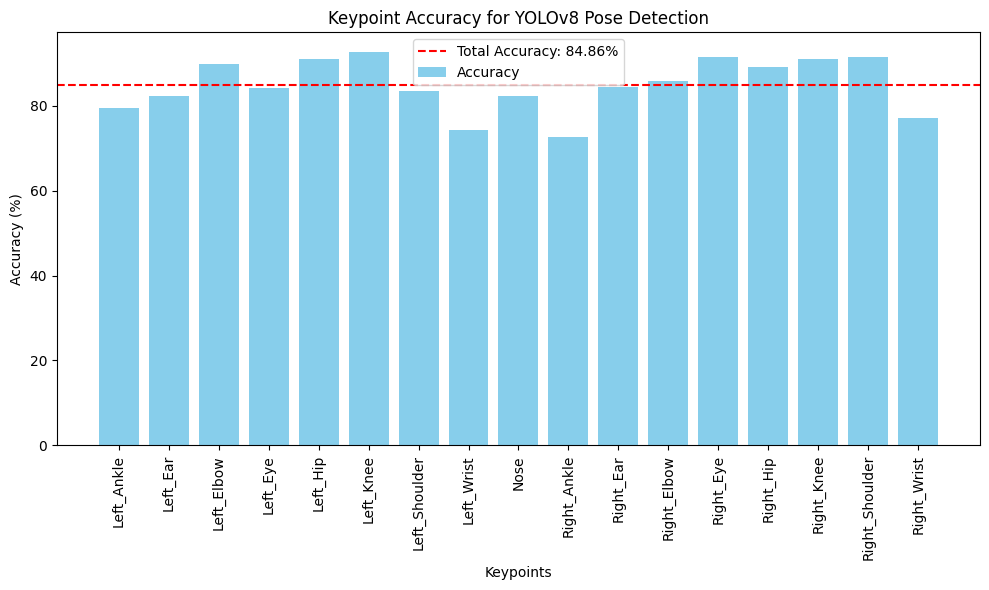


Temporal Stability:
           Keypoint  Standard Deviation   Accuracy  Adjusted Accuracy
0       Left_Ankle            2.056601  79.433994          79.433994
1         Left_Ear            1.770551  82.294493          82.294493
2       Left_Elbow            1.026633  89.733673          89.733673
3         Left_Eye            1.580735  84.192650          84.192650
4         Left_Hip            0.889972  91.100278          91.100278
5        Left_Knee            0.735471  92.645291          92.645291
6    Left_Shoulder            1.653341  83.466594          83.466594
7       Left_Wrist            2.563078  74.369223          74.369223
8             Nose            1.778857  82.211428          82.211428
9      Right_Ankle            2.733582  72.664185          72.664185
10       Right_Ear            1.558407  84.415928          84.415928
11     Right_Elbow            1.411461  85.885389          85.885389
12       Right_Eye            0.846383  91.536174          91.536174
13       Rig

In [52]:
import os
from ultralytics import YOLO
import cv2 as cv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Load YOLO model
model = YOLO('yolov8x-pose.pt')

# Directories
input_folder = r'C:\Users\AMUS\python\Dataset\2023-03-20\camera1\test3'
output_folder = r'C:\Users\AMUS\python\Dataset\2023-03-20\camera1\test3\yolo_check'
csv_folder = r'C:\Users\AMUS\python\mediapipe'

# Ensure folders exist
os.makedirs(output_folder, exist_ok=True)
os.makedirs(csv_folder, exist_ok=True)

# Calibration parameters
min_temp = 23
max_temp = 35
lut = np.linspace(min_temp, max_temp, 256)

custom_labels = {
    0: "Nose", 1: "Left_Eye", 2: "Right_Eye", 3: "Left_Ear", 4: "Right_Ear",
    5: "Left_Shoulder", 6: "Right_Shoulder", 7: "Left_Elbow", 8: "Right_Elbow",
    9: "Left_Wrist", 10: "Right_Wrist", 11: "Left_Hip", 12: "Right_Hip",
    13: "Left_Knee", 14: "Right_Knee", 15: "Left_Ankle", 16: "Right_Ankle"
}

# Define the region of interest (ROI)
roi_top_left = (250, 90)  # (x, y)
roi_bottom_right = (450, 600)  # (x, y)

# Functions
def calculate_temporal_stability(df):
    """Calculate temporal stability based on temperature variations."""
    stability_df = df.groupby("Keypoint")["Temperature (°C)"].std().reset_index()
    stability_df.rename(columns={"Temperature (°C)": "Standard Deviation"}, inplace=True)
    return stability_df

def calculate_accuracy_from_sd(stability_df):
    """Calculate accuracy from standard deviation."""
    stability_df["Accuracy"] = 100 - (stability_df["Standard Deviation"] * 10)  # Example calculation
    return stability_df

def calculate_symmetry(df):
    """Analyze symmetry by comparing left and right body parts."""
    symmetry_data = []
    for left, right in [("Left_Shoulder", "Right_Shoulder"), 
                        ("Left_Elbow", "Right_Elbow"), 
                        ("Left_Wrist", "Right_Wrist")]:
        left_temp = df[df["Keypoint"] == left]["Temperature (°C)"].mean()
        right_temp = df[df["Keypoint"] == right]["Temperature (°C)"].mean()
        symmetry_data.append({"Left": left, "Right": right, "Difference": abs(left_temp - right_temp)})
    return pd.DataFrame(symmetry_data)

def calculate_region_temperature_consistency(df):
    """Calculate consistency across regions.""" 
    region_df = df.groupby("Keypoint")["Temperature (°C)"].mean().reset_index()
    region_df["Consistency"] = 100 - abs(region_df["Temperature (°C)"] - region_df["Temperature (°C)"].mean())
    return region_df

def calculate_adjusted_accuracy(accuracy_df, detected_keypoints_per_frame, total_keypoints=17):
    """Calculate adjusted accuracy based on number of detected keypoints.""" 
    accuracy_df["Adjusted Accuracy"] = accuracy_df["Accuracy"] * (detected_keypoints_per_frame / total_keypoints)
    return accuracy_df

def process_frame(frame, filename, output_folder):
    """Process a single frame for keypoints and temperature analysis within ROI."""
    thermal_image = cv.cvtColor(frame, cv.COLOR_BGR2GRAY)
    temperature_image = lut[thermal_image]
    results = model(frame)
    keypoints = results[0].keypoints
    keypoints_xy = keypoints.xy.numpy() if keypoints is not None else []
    frame_results = []
    detected_keypoints = 0

    for person_keypoints in keypoints_xy:
        keypoints_within_roi = 0

        for i, kpt in enumerate(person_keypoints):
            x, y = int(kpt[0]), int(kpt[1])
            
            # Check if keypoint is within the ROI
            if (roi_top_left[0] <= x <= roi_bottom_right[0]) and (roi_top_left[1] <= y <= roi_bottom_right[1]):
                keypoints_within_roi += 1

        # Skip processing if keypoints within ROI are <= 50% of the person's keypoints
        if keypoints_within_roi <= len(person_keypoints) * 0.6:
            continue

        for i, kpt in enumerate(person_keypoints):
            x, y = int(kpt[0]), int(kpt[1])

            if (roi_top_left[0] <= x <= roi_bottom_right[0]) and (roi_top_left[1] <= y <= roi_bottom_right[1]):
                detected_keypoints += 1
                if 0 <= x < temperature_image.shape[1] and 0 <= y < temperature_image.shape[0]:
                    temp_at_point = temperature_image[y, x]
                    frame_results.append({
                        "Image": filename,
                        "Keypoint": custom_labels.get(i, f"Keypoint_{i}"),
                        "Temperature (°C)": temp_at_point
                    })
                    # Annotate keypoints within ROI
                    cv.circle(frame, (x, y), 3, (0, 255, 0), -1)
                    cv.putText(frame, f"{temp_at_point:.1f}C", (x, y - 5), cv.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 1)

    # Draw ROI on the frame
    cv.rectangle(frame, roi_top_left, roi_bottom_right, (255, 0, 0), 2)
    annotated_path = os.path.join(output_folder, f"annotated_{filename}")
    cv.imwrite(annotated_path, frame)
    return frame_results, detected_keypoints

# Process images
results_list = []
detected_keypoints_per_frame = 0
for filename in os.listdir(input_folder):
    if filename.lower().endswith((".tiff", ".png", ".jpg")):
        frame = cv.imread(os.path.join(input_folder, filename), cv.IMREAD_UNCHANGED)
        if frame is not None:
            frame_results, detected_keypoints = process_frame(frame, filename, output_folder)
            results_list.extend(frame_results)
            detected_keypoints_per_frame = max(detected_keypoints_per_frame, detected_keypoints)

# Convert results to DataFrame
df = pd.DataFrame(results_list)

# Analyze data
temporal_stability = calculate_temporal_stability(df)
accuracy_df = calculate_accuracy_from_sd(temporal_stability)
accuracy_df = calculate_adjusted_accuracy(accuracy_df, detected_keypoints_per_frame)
total_accuracy = accuracy_df['Adjusted Accuracy'].mean()

symmetry_df = calculate_symmetry(df)
region_consistency_df = calculate_region_temperature_consistency(df)

# Save analysis to CSV
csv_path = os.path.join(csv_folder, 'processed_data.csv')
df.to_csv(csv_path, index=False)

# Visualization
plt.figure(figsize=(10, 6))
plt.bar(accuracy_df['Keypoint'], accuracy_df['Adjusted Accuracy'], color='skyblue', label='Accuracy')
plt.axhline(y=total_accuracy, color='red', linestyle='--', label=f'Total Accuracy: {total_accuracy:.2f}%')
plt.xticks(rotation=90)
plt.xlabel('Keypoints')
plt.ylabel('Accuracy (%)')
plt.title('Keypoint Accuracy for YOLOv8 Pose Detection')
plt.legend()
plt.tight_layout()
plt.show()

# Print results
print("\nTemporal Stability:\n", temporal_stability)
print("\nSymmetry Analysis:\n", symmetry_df)
print("\nRegion Temperature Consistency:\n", region_consistency_df)



0: 480x640 3 persons, 1119.3ms
Speed: 2.0ms preprocess, 1119.3ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 5 persons, 1094.2ms
Speed: 2.0ms preprocess, 1094.2ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 1135.8ms
Speed: 2.0ms preprocess, 1135.8ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 1077.4ms
Speed: 2.0ms preprocess, 1077.4ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 1101.4ms
Speed: 2.0ms preprocess, 1101.4ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 1122.3ms
Speed: 1.2ms preprocess, 1122.3ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 1151.3ms
Speed: 2.0ms preprocess, 1151.3ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 5 persons, 1182.8ms
Speed: 1.0ms preprocess, 1182.8ms inference, 1.0ms 

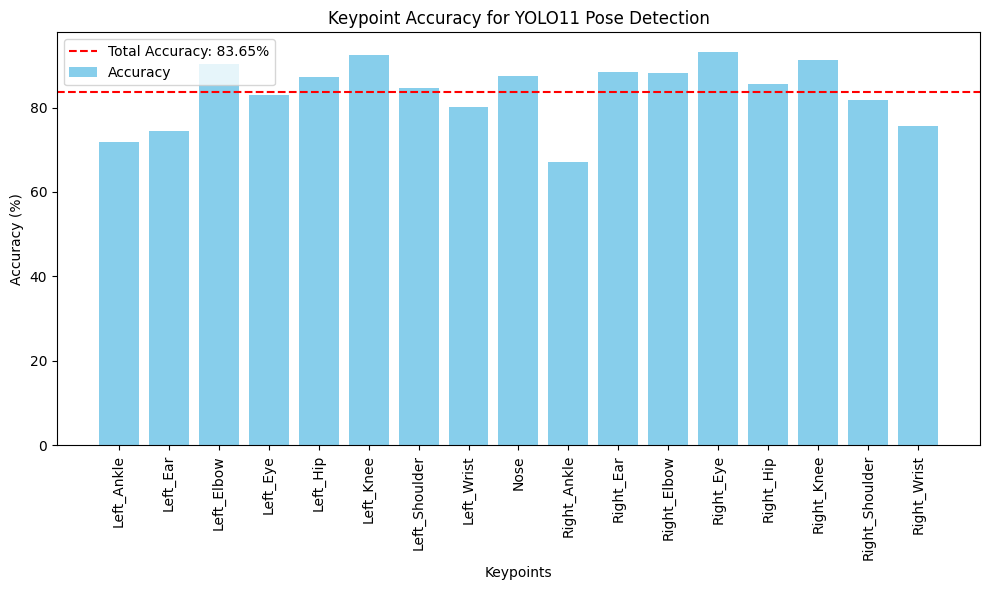


Temporal Stability:
           Keypoint  Standard Deviation   Accuracy  Adjusted Accuracy
0       Left_Ankle            2.827467  71.725328          71.725328
1         Left_Ear            2.545952  74.540475          74.540475
2       Left_Elbow            0.964658  90.353416          90.353416
3         Left_Eye            1.698995  83.010051          83.010051
4         Left_Hip            1.280312  87.196881          87.196881
5        Left_Knee            0.765641  92.343591          92.343591
6    Left_Shoulder            1.535103  84.648975          84.648975
7       Left_Wrist            1.994823  80.051766          80.051766
8             Nose            1.261432  87.385679          87.385679
9      Right_Ankle            3.298526  67.014735          67.014735
10       Right_Ear            1.167200  88.328005          88.328005
11     Right_Elbow            1.191449  88.085508          88.085508
12       Right_Eye            0.684921  93.150793          93.150793
13       Rig

In [53]:
import os
from ultralytics import YOLO
import cv2 as cv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Load YOLO model
model = YOLO('yolo11x-pose.pt')

# Directories
input_folder = r'C:\Users\AMUS\python\Dataset\2023-03-20\camera1\test3'
output_folder = r'C:\Users\AMUS\python\Dataset\2023-03-20\camera1\test3\yolo_check11'
csv_folder = r'C:\Users\AMUS\python\mediapipe'

# Ensure folders exist
os.makedirs(output_folder, exist_ok=True)
os.makedirs(csv_folder, exist_ok=True)

# Calibration parameters
min_temp = 23
max_temp = 35
lut = np.linspace(min_temp, max_temp, 256)

custom_labels = {
    0: "Nose", 1: "Left_Eye", 2: "Right_Eye", 3: "Left_Ear", 4: "Right_Ear",
    5: "Left_Shoulder", 6: "Right_Shoulder", 7: "Left_Elbow", 8: "Right_Elbow",
    9: "Left_Wrist", 10: "Right_Wrist", 11: "Left_Hip", 12: "Right_Hip",
    13: "Left_Knee", 14: "Right_Knee", 15: "Left_Ankle", 16: "Right_Ankle"
}

# Define the region of interest (ROI)
roi_top_left = (250, 90)  # (x, y)
roi_bottom_right = (450, 600)  # (x, y)

# Functions
def calculate_temporal_stability(df):
    """Calculate temporal stability based on temperature variations."""
    stability_df = df.groupby("Keypoint")["Temperature (°C)"].std().reset_index()
    stability_df.rename(columns={"Temperature (°C)": "Standard Deviation"}, inplace=True)
    return stability_df

def calculate_accuracy_from_sd(stability_df):
    """Calculate accuracy from standard deviation."""
    stability_df["Accuracy"] = 100 - (stability_df["Standard Deviation"] * 10)  # Example calculation
    return stability_df

def calculate_symmetry(df):
    """Analyze symmetry by comparing left and right body parts."""
    symmetry_data = []
    for left, right in [("Left_Shoulder", "Right_Shoulder"), 
                        ("Left_Elbow", "Right_Elbow"), 
                        ("Left_Wrist", "Right_Wrist")]:
        left_temp = df[df["Keypoint"] == left]["Temperature (°C)"].mean()
        right_temp = df[df["Keypoint"] == right]["Temperature (°C)"].mean()
        symmetry_data.append({"Left": left, "Right": right, "Difference": abs(left_temp - right_temp)})
    return pd.DataFrame(symmetry_data)

def calculate_region_temperature_consistency(df):
    """Calculate consistency across regions.""" 
    region_df = df.groupby("Keypoint")["Temperature (°C)"].mean().reset_index()
    region_df["Consistency"] = 100 - abs(region_df["Temperature (°C)"] - region_df["Temperature (°C)"].mean())
    return region_df

def calculate_adjusted_accuracy(accuracy_df, detected_keypoints_per_frame, total_keypoints=17):
    """Calculate adjusted accuracy based on number of detected keypoints.""" 
    accuracy_df["Adjusted Accuracy"] = accuracy_df["Accuracy"] * (detected_keypoints_per_frame / total_keypoints)
    return accuracy_df

def process_frame(frame, filename, output_folder):
    """Process a single frame for keypoints and temperature analysis within ROI."""
    thermal_image = cv.cvtColor(frame, cv.COLOR_BGR2GRAY)
    temperature_image = lut[thermal_image]
    results = model(frame)
    keypoints = results[0].keypoints
    keypoints_xy = keypoints.xy.numpy() if keypoints is not None else []
    frame_results = []
    detected_keypoints = 0

    for person_keypoints in keypoints_xy:
        keypoints_within_roi = 0

        for i, kpt in enumerate(person_keypoints):
            x, y = int(kpt[0]), int(kpt[1])
            
            # Check if keypoint is within the ROI
            if (roi_top_left[0] <= x <= roi_bottom_right[0]) and (roi_top_left[1] <= y <= roi_bottom_right[1]):
                keypoints_within_roi += 1

        # Skip processing if keypoints within ROI are <= 50% of the person's keypoints
        if keypoints_within_roi <= len(person_keypoints) * 0.5:
            continue

        for i, kpt in enumerate(person_keypoints):
            x, y = int(kpt[0]), int(kpt[1])

            if (roi_top_left[0] <= x <= roi_bottom_right[0]) and (roi_top_left[1] <= y <= roi_bottom_right[1]):
                detected_keypoints += 1
                if 0 <= x < temperature_image.shape[1] and 0 <= y < temperature_image.shape[0]:
                    temp_at_point = temperature_image[y, x]
                    frame_results.append({
                        "Image": filename,
                        "Keypoint": custom_labels.get(i, f"Keypoint_{i}"),
                        "Temperature (°C)": temp_at_point
                    })
                    # Annotate keypoints within ROI
                    cv.circle(frame, (x, y), 3, (0, 255, 0), -1)
                    cv.putText(frame, f"{temp_at_point:.1f}C", (x, y - 5), cv.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 1)

    # Draw ROI on the frame
    cv.rectangle(frame, roi_top_left, roi_bottom_right, (255, 0, 0), 2)
    annotated_path = os.path.join(output_folder, f"annotated_{filename}")
    cv.imwrite(annotated_path, frame)
    return frame_results, detected_keypoints

# Process images
results_list = []
detected_keypoints_per_frame = 0
for filename in os.listdir(input_folder):
    if filename.lower().endswith((".tiff", ".png", ".jpg")):
        frame = cv.imread(os.path.join(input_folder, filename), cv.IMREAD_UNCHANGED)
        if frame is not None:
            frame_results, detected_keypoints = process_frame(frame, filename, output_folder)
            results_list.extend(frame_results)
            detected_keypoints_per_frame = max(detected_keypoints_per_frame, detected_keypoints)

# Convert results to DataFrame
df = pd.DataFrame(results_list)

# Analyze data
temporal_stability = calculate_temporal_stability(df)
accuracy_df = calculate_accuracy_from_sd(temporal_stability)
accuracy_df = calculate_adjusted_accuracy(accuracy_df, detected_keypoints_per_frame)
total_accuracy = accuracy_df['Adjusted Accuracy'].mean()

symmetry_df = calculate_symmetry(df)
region_consistency_df = calculate_region_temperature_consistency(df)

# Save analysis to CSV
csv_path = os.path.join(csv_folder, 'processed_data.csv')
df.to_csv(csv_path, index=False)

# Visualization
plt.figure(figsize=(10, 6))
plt.bar(accuracy_df['Keypoint'], accuracy_df['Adjusted Accuracy'], color='skyblue', label='Accuracy')
plt.axhline(y=total_accuracy, color='red', linestyle='--', label=f'Total Accuracy: {total_accuracy:.2f}%')
plt.xticks(rotation=90)
plt.xlabel('Keypoints')
plt.ylabel('Accuracy (%)')
plt.title('Keypoint Accuracy for YOLO11 Pose Detection')
plt.legend()
plt.tight_layout()
plt.show()

# Print results
print("\nTemporal Stability:\n", temporal_stability)
print("\nSymmetry Analysis:\n", symmetry_df)
print("\nRegion Temperature Consistency:\n", region_consistency_df)
